In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import datetime
import glob
import os
import pandas as pd

from torch.utils.data import DataLoader

from model.custom_model import CustomAudioCLIP
from utils.audiolist import AudioList

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parse the folders (match audio path with result path)

In [3]:
def remove_extension(input):

    filename = input.split("/")[-1].split(".")[0]

    if len(filename) > 2:
        filename = ".".join(filename[0:-1])
    else:
        filename = input.split("/")[-1].split(".")[0]

    return filename

def parseFolders(apath, rpath):

    audio_files = [f for f in glob.glob(apath + "/**/*", recursive = True) if os.path.isfile(f)]
    audio_no_extension = []
    for audio_file in audio_files:
        audio_file_no_extension = remove_extension(audio_file)
        audio_no_extension.append(audio_file_no_extension)


    result_files = [f for f in glob.glob(rpath + "/**/*", recursive = True) if os.path.isfile(f)]

    flist = []
    for result in result_files:
        result_no_extension = remove_extension(result)
        is_in = result_no_extension in audio_no_extension

        if is_in:
            audio_idx = audio_no_extension.index(result_no_extension)
            pair = {'audio': audio_files[audio_idx], 'result': result}
            flist.append(pair)
        else:
            continue

    print('Found {} audio files with valid result file.'.format(len(flist)))

    return flist


In [10]:
df_all = {"Selection": [], "View": [], "Channel": [], "Begin Time (s)": [], "End Time (s)": [], "Low Freq (Hz)": [], "High Freq (Hz)": [], "type": [], "comment": []}
df_all = pd.DataFrame(df_all)

In [ ]:
# NEED TO RUN THE MODEL FIRST ON THE DATA
# THEN CROSS CHECK THE DETECTIONS

# Run the model on the audio files 

In [20]:
import numpy as np
import torch
import yaml
import itertools
import glob
import pandas as pd

from torch.quantization import quantize_dynamic
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

from utils.audio_processing import openAudioFile, splitSignal

class AudioList():

    def __init__(self, length_segments = 3, overlap = 0, sample_rate=44100):
        self.sample_rate = sample_rate
        self.length_segments = length_segments
        self.overlap = overlap
        
    def read_audio(self, audio_path):
        """Read the audio, change the sample rate and randomly pick one channel"""
        sig, _ = openAudioFile(audio_path, sample_rate=self.sample_rate)
        return sig

    def split_segment(self, array):
        splitted_array = splitSignal(array, rate=self.sample_rate, seconds=self.length_segments, overlap=self.overlap, minlen=3)
        return splitted_array

    def get_processed_list(self, audio_path):

        list_segments = []

        track = self.read_audio(audio_path)        
        list_divided = self.split_segment(track)
        list_segments.append(list_divided)
        return list_segments

class AudioLoader(Dataset):
    def __init__(self, list_data, sr=44100, transform=None):
        self.data = list_data
        self.transform = transform
        self.sr=sr

    def __len__(self):
        return len(self.data)

    def process_data(self, data):

        array = data
        array = array.reshape(1, -1)
        array = torch.tensor(array)
        return array

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tensor = self.process_data(self.data[idx])
        return tensor 

def getPredLoader(list_arrays):
    list_preds = AudioLoader(list_arrays)
    predLoader = DataLoader(list_preds, batch_size=1, num_workers=4, pin_memory=False)
    return predLoader

def predict(testLoader, model):

    proba_list = []

    for array in testLoader:
        tensor = array
        output = model(tensor)
        output = np.exp(output.detach().numpy())
        proba_list.append(output[0][1])

    return (np.array(proba_list))

def initModel(model_path):
    m = torch.load(model_path).eval()
    #m_q = quantize_dynamic(m, qconfig_spec={torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8)
    return m

In [17]:
label_path = "/Data/test_dataset/labels"
audio_test_path = "/Data/test_dataset/audio"
mpath = "/app/assets/anode.pth"

In [8]:
flist = parseFolders(audio_test_path, label_path)

Found 67 audio files with valid result file.


In [9]:
#for i in range(len(flist)):
#    filename = flist[i]['audio']
#    AudioList().get_processed_list(filename)

In [10]:
l_audio = AudioList().get_processed_list(flist[5]['audio'])

/opt/conda/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [14]:
t = []
l_segments = 3
overlap = 2

for i, _ in enumerate(l_audio[0]):
    instant = i*l_segments
    t.append(instant)

In [23]:
m = initModel(mpath)

In [26]:
test_loader = getPredLoader(l_audio[0])

In [28]:
p = predict(test_loader, m)

# Ground truth the predictions

In [76]:
df = pd.read_csv(flist[5]['result'], sep='\t').filter(items=["Begin Time (s)", "End Time (s)", "View"])
df = df[df['View'] == 'Spectrogram 1'].reset_index()

In [89]:
predicted_label = []

for i in range(len(df)):

    begin_time = df.loc[i]['Begin Time (s)']
    end_time = df.loc[i]['End Time (s)']

    if begin_time <= a <= end_time:
        predicted_label.append(1)
        break
    else:
        continue
    
    predicted_label.append(0)


In [91]:
l_segments = 3
overlap = 0
time_index = 0
threshold = 0.9

In [107]:
# transform p as binary with regards to the threshold
p_bin = []

for pred in p:
    if pred >= threshold:
        p_bin.append(1)
    else:
        p_bin.append(0)

p_bin = np.array(p_bin)

In [110]:
p_bin

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,

In [131]:
# GROUND TRUTH TO BINARY
gt = []

for i in range(len(l_audio[0])):

    if i > 0:
        i = i * (l_segments - overlap)
        
    is_in_df = False

    for j in range(len(df)):

        begin_time = df.loc[j]['Begin Time (s)']
        end_time = df.loc[j]['End Time (s)']

        if begin_time <= i <= end_time:
            is_in_df = True
        else:
            continue
    
    if is_in_df:
        gt.append(1)
    else: 
        gt.append(0)

gt = np.array(gt)

In [123]:
df

,index,Begin Time (s),End Time (s),View
0,1,98.991993,116.325299,Spectrogram 1
1,3,148.106717,216.665269,Spectrogram 1
2,5,294.082802,309.237341,Spectrogram 1
3,7,631.682612,649.839008,Spectrogram 1
4,9,661.277048,682.241633,Spectrogram 1
5,11,743.505708,755.900475,Spectrogram 1
6,13,785.871505,830.996201,Spectrogram 1
7,15,879.198977,898.323714,Spectrogram 1
8,17,1232.273843,1256.433954,Spectrogram 1
9,19,1322.651746,1368.115361,Spectrogram 1


In [134]:
gt

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,

In [137]:
from sklearn.metrics import confusion_matrix

confusion_matrix(gt, p_bin)

array([[464,  23],
       [ 17,  95]])

In [142]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [143]:
fpr, tpr, _ = roc_curve(gt, p)
roc_auc = auc(fpr, tpr)

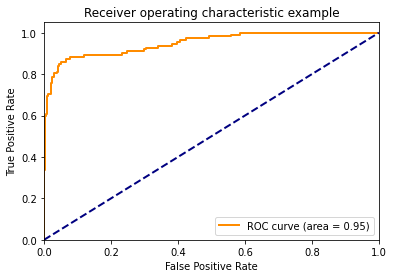

In [144]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

,Begin Time (s),End Time (s)
0,98.991993,116.325299
1,98.991993,116.325299
2,148.106717,216.665269
3,148.106717,216.665269
4,294.082802,309.237341
5,294.082802,309.237341
6,631.682612,649.839008
7,631.682612,649.839008
8,661.277048,682.241633
9,661.277048,682.241633


In [6]:

m = initModel("/app/assets/ckpt-epoch=21-val_loss=0.12-lr=0.005.ckpt")



# OTHER SCRIPTS

In [81]:
import numpy as np
import torch
import yaml
import itertools
import glob
import pandas as pd

from torch.quantization import quantize_dynamic
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

from utils import openAudioFile, splitSignal

class AudioListNoLabels():

    def __init__(self, length_segments = 3, sample_rate=44100):
        self.sample_rate = sample_rate
        self.length_segments = length_segments
        
    def read_audio(self, audio_path):
        """Read the audio, change the sample rate and randomly pick one channel"""
        sig, _ = openAudioFile(audio_path, sample_rate=self.sample_rate)
        return sig

    def split_segment(self, array):
        splitted_array = splitSignal(array, rate=self.sample_rate, seconds=self.length_segments, overlap=0, minlen=3)
        return splitted_array

    def get_processed_list(self, audio_path):

        list_segments = []

        for item in audio_path:
            track = self.read_audio(item)        
            label = item.split("/")[-2]
            list_divided = self.split_segment(track)
            list_segments.append(list_divided)
        return list_segments

class AudioLoader(Dataset):
    def __init__(self, list_data, label_encoder, sr=44100, transform=None):
        self.data = list_data
        self.label_encoder = label_encoder
        self.transform = transform
        self.sr=sr

    def __len__(self):
        return len(self.data)

    def process_data(self, data):

        array, label = data
        array = array.reshape(1, -1)
        array = torch.tensor(array)

        label_encoded = self.label_encoder.one_hot_sample(label)
        label_class = torch.argmax(label_encoded)

        return (array, label_class)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tensor, label = self.process_data(self.data[idx])
        return tensor, label

    def get_labels(self):
        list_labels = []
        for x,y in self.data:
            list_labels.append(y)
        return list_labels

def initModel(model_path):
    m = torch.load(model_path).eval()
    m_q = quantize_dynamic(m, qconfig_spec={torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8)
    return m_q
    
def getPredLoader(list_arrays, l):
    list_preds = AudioLoader(list_arrays, label_encoder)
    predLoader = DataLoader(list_preds, batch_size=1, num_workers=4, pin_memory=False)
    return predLoader

def predict(testLoader, model):

    proba_list = []
    label_list = []

    for array, label in testLoader:
        tensor = torch.tensor(array)
        output = model(tensor)
        output = np.exp(output.detach().numpy())
        proba_list.append(output[0][1])
        label_list.append(label[0])

    return (np.array(proba_list), np.array(label_list))

In [47]:
with open("/app/prediction_scripts/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [48]:

###################
# Get the dataset #
###################

allFiles = [f for f in glob.glob(config["INPUT_PATH"] + "/**/*", recursive=True) if os.path.isfile(f)]
allFiles = [f for f in allFiles if f.endswith( (".WAV", ".wav", ".mp3") )]

# Instantiate the audio iterator class - cut the audio into segments
audio_list= AudioList(length_segments=config["SIG_LENGTH"], sample_rate=config["SAMPLE_RATE"])

list_test = audio_list.get_processed_list(allFiles)
list_test = list(itertools.chain.from_iterable(list_test))

###########################
# Create the labelEncoder #
###########################
label_encoder = EncodeLabels(path_to_folders=config["INPUT_PATH"])

# Save name of the folder and associated label in a json file
l = label_encoder.__getLabels__()
t = label_encoder.class_encode.transform(l)

folder_labels = []
for i, j in zip(l,t):
    item = {"Folder": i, "Label": int(j)}
    folder_labels.append(item)

In [79]:
audioloader = AudioLoader(list_test, label_encoder)
predLoader = DataLoader(audioloader, batch_size=1, num_workers=4, pin_memory=False)
model = initModel(config["MODEL"])
proba_list, labels = predict(predLoader, model)

/tmp/ipykernel_9453/222997309.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(array)


In [92]:
precision, recall, thresholds = precision_recall_curve(labels, proba_list)
thresholds = np.append(thresholds, 1)

In [94]:
d = {'thresholds': thresholds, 'precision': precision, 'recall': recall}
df = pd.DataFrame(data=d)

: 

In [14]:
import pandas as pd
import glob
import os

path = '/Data/audioCLIP/results' # use your path
all_files = glob.glob(path + "/*")
print(all_files)
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_conf = df[df["confidence"] > 0.99]
    print(len(df_conf))
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

['/Data/audioCLIP/results/YELLMACS_20120131_105013.csv', '/Data/audioCLIP/results/YELLPAYP_20130124_083717.csv', '/Data/audioCLIP/results/YELLMJ2B_20140327_154332.csv', '/Data/audioCLIP/results/YELLSYL3_20130206_223122.csv', '/Data/audioCLIP/results/YELLMM8K_20080214_021244.csv', '/Data/audioCLIP/results/YELLSYL3_20130207_075037.csv', '/Data/audioCLIP/results/YELLFOPP_20141229_110225.csv', '/Data/audioCLIP/results/YELLMJ23_20111229_154155.csv']
275
808
37
0
0
13
568
578


In [17]:
! ffmpeg -i /Data/audioCLIP/files_to_split/YELLCRPA_20110112_060550.MP3 -c copy -map 0 -segment_time 00:30:00 -f segment /Data/audioCLIP/output%03d.mp3

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
[mp3 @ 0x55be63d6ccc0] Estimating duration from bitrate, this may be inaccurate
Input #0, mp3, from '/Data/audioCLIP/files_to_split/YELLCRPA_20110112_060550.MP3':
  Durat